In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from datetime import datetime
from sklearn.datasets import load_breast_cancer
main_start = datetime.now()
%matplotlib inline

In [2]:
main_start = datetime.now()
raw_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
raw_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
#Drop ID since that will be unique to each row and we already have the Pandas index as a key
data = raw_data.drop(['customerID'], 1)
#Get our types
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
data['TotalCharges'] = data['TotalCharges'].convert_objects(convert_numeric=True)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [5]:
# Count nulls 
null_count = data.isnull().sum()
null_count[null_count>0]

TotalCharges    11
dtype: int64

In [6]:
data = data.dropna(axis=0)
# Count nulls 
null_count = data.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [7]:
#Get the values from our columns that are listed as strings
column_names = list(data.columns.values)

#Remove the int/float categories
del column_names[1]
del column_names[3]
del column_names[15]
del column_names[15]

for columns in column_names:
    print(columns,'\n', raw_data[columns].value_counts(), '\n')

gender 
 Male      3555
Female    3488
Name: gender, dtype: int64 

Partner 
 No     3641
Yes    3402
Name: Partner, dtype: int64 

Dependents 
 No     4933
Yes    2110
Name: Dependents, dtype: int64 

PhoneService 
 Yes    6361
No      682
Name: PhoneService, dtype: int64 

MultipleLines 
 No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 

InternetService 
 Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

OnlineSecurity 
 No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64 

OnlineBackup 
 No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64 

DeviceProtection 
 No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64 

TechSupport 
 No                     3473
Yes                    20

In [8]:
#For the columns that only have 2 values, let's convert them to 0s and 1s
Yes_No_Columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for feature in Yes_No_Columns:
    data[feature] = np.where(data[feature].values == 'Yes', 1, 0)

#Now let's convert the Males/Females in 0 (Males) and 1 (Females)
data['gender'] = np.where(data.gender.values == 'Female', 1, 0)
    
data.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1
5,1,0,0,0,8,1,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,99.65,820.50,1
6,0,0,0,1,22,1,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,1,Credit card (automatic),89.10,1949.40,0
7,1,0,0,0,10,0,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,0,Mailed check,29.75,301.90,0
8,1,0,1,0,28,1,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,1,Electronic check,104.80,3046.05,1
9,0,0,0,1,62,1,No,DSL,Yes,Yes,No,No,No,No,One year,0,Bank transfer (automatic),56.15,3487.95,0


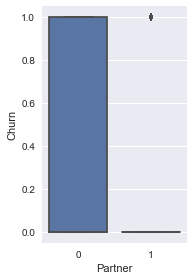

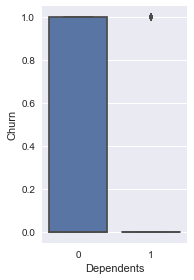

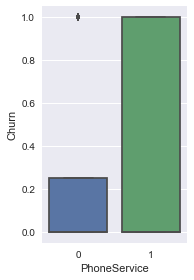

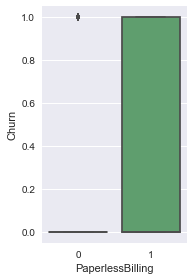

In [9]:
del Yes_No_Columns[4]
for feature in Yes_No_Columns:
    sns.factorplot(x=feature, y='Churn', data=data, kind="box", size=4, aspect=.7)
    plt.show()

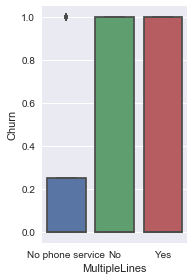

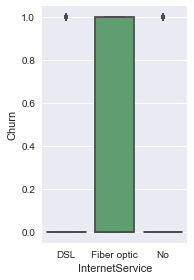

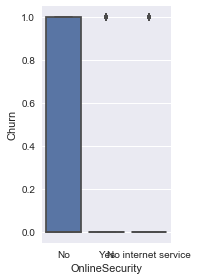

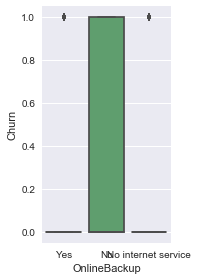

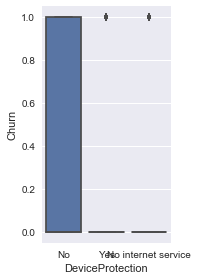

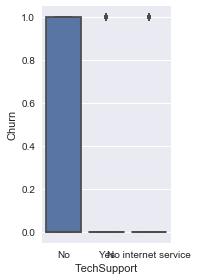

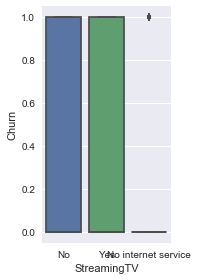

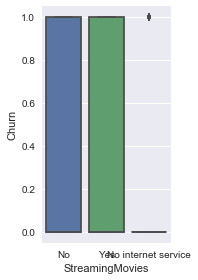

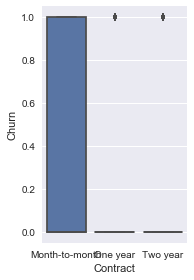

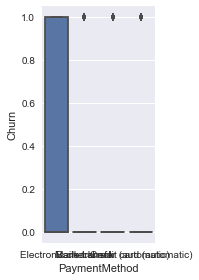

In [10]:
multiple_answers = ['MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']
for feature in multiple_answers:
    sns.factorplot(x=feature, y='Churn', data=data, kind="box", size=4, aspect=.7)
    plt.show()

In [11]:
#Let's get dummies for the columns with multiple answers
data = pd.get_dummies(data, columns=multiple_answers)
data.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                

In [12]:
data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.495307,0.162400,0.482509,0.298493,32.421786,0.903299,0.592719,64.798208,2283.300441,0.265785,...,0.395478,0.216155,0.388367,0.551052,0.209329,0.239619,0.219283,0.216297,0.336320,0.228100
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.491363,30.085974,2266.771362,0.441782,...,0.488988,0.411650,0.487414,0.497422,0.406858,0.426881,0.413790,0.411748,0.472483,0.419637
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.587500,401.450000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.862500,3794.737500,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


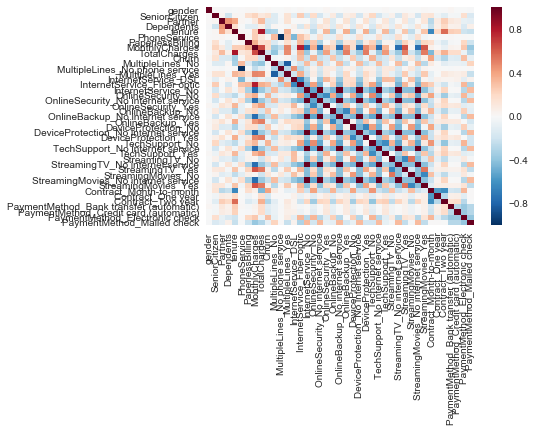

In [13]:
#Check their relationship with a heatmap
sns.heatmap(data.corr())

In [14]:
def basic_test(test):
    #Fit the models
    test.fit(X, y)
    #Generate the score
    print('Accuracy on the training data with no feature selection: {}'.format(test.score(X, y)))
    print('\nCross Validation with 5 folds: {}'.format(cross_val_score(test, X, y, cv=5)) )

X = data.drop(['Churn'], 1)
y = data['Churn']

In [15]:
lr = LogisticRegression(C=1, penalty='l1')
basic_test(lr)
  

Accuracy on the training data with no feature selection: 0.8064562002275313

Cross Validation with 5 folds: [ 0.80312722  0.8137882   0.79104478  0.8086771   0.80427046]


In [16]:
lr = LogisticRegression(C=1, penalty='l2')
basic_test(lr)

Accuracy on the training data with no feature selection: 0.805745164960182

Cross Validation with 5 folds: [ 0.80312722  0.81236674  0.78962331  0.81507824  0.80498221]


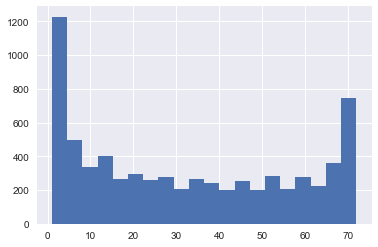

In [17]:
plt.hist(data['tenure'], bins=20)
plt.show()

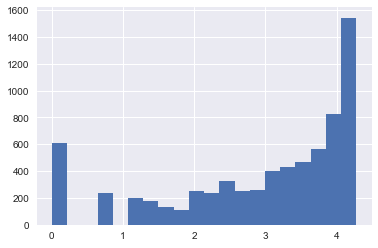

In [18]:
data['tenure_log'] = np.log(data['tenure'])
plt.hist(data['tenure_log'], bins=20)
plt.show()

In [19]:
threshold = 30
data['tenure_binary'] = np.where(data['tenure'] >= threshold, 1, 0)
data['tenure_binary'].value_counts()

0    3558
1    3474
Name: tenure_binary, dtype: int64

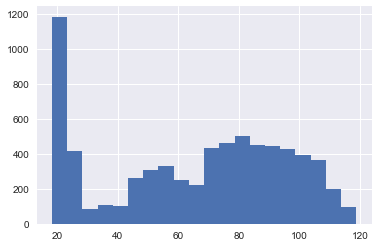

In [20]:
plt.hist(data['MonthlyCharges'], bins=20)
plt.show()

In [21]:
threshold = 65.0
data['expensive'] = np.where(data['MonthlyCharges'] >= threshold, 1, 0)
data['expensive'].value_counts()

1    3902
0    3130
Name: expensive, dtype: int64

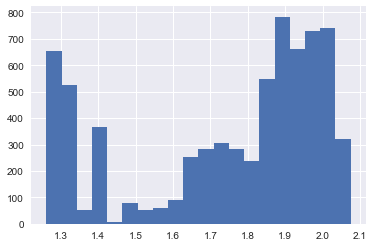

In [22]:
data['MonthlyCharges_log'] = np.log10(data['MonthlyCharges'])
plt.hist(data['MonthlyCharges_log'], bins=20)
plt.show()

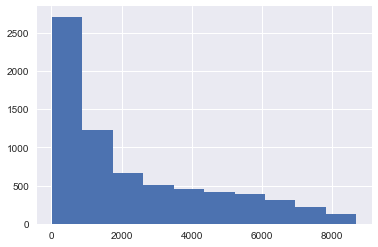

In [23]:
plt.hist(data['TotalCharges'], bins=10)
plt.show()

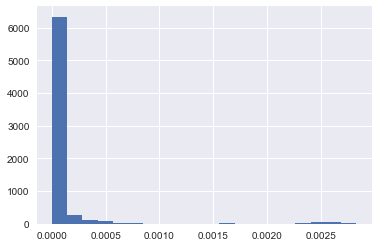

In [24]:
data['TotalCharges_sqrt'] = data['TotalCharges'] ** -2
plt.hist(data['TotalCharges_sqrt'], bins=20)
plt.show()

In [25]:
yes_churn = data[data.Churn == 1]
no_churn = data[data.Churn == 0]

data = resample(no_churn, n_samples=1869)
data = data.append(yes_churn)

X = data.drop(['Churn'], 1)
y = data['Churn']

#Make a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


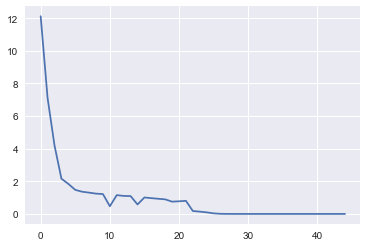

In [26]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(X_train)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

In [27]:
#Set up our first X using PCA
pca = PCA(n_components=4)
X_std_pca = pca.fit_transform(X_train)
X1 = pd.DataFrame(X_std_pca)

#Now for the Test
pca = PCA(n_components=4)
X_std_pca = pca.fit_transform(X_test)
X1_test = pd.DataFrame(X_std_pca)

In [28]:
start = datetime.now()
#Use Lasso/RFE with Cross Validation to get the best features for our second X
lr = LogisticRegression(C=1, penalty='l1')

#Set up our X,y
X = X_train
y = y_train

#Set up our Recursive Feature Elimination
rfe = RFECV(lr,cv=5) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))
print('It took the following time to complete this task:', datetime.now() - start)

                                   Features  Ranking  Support
1                             SeniorCitizen        1     True
36  PaymentMethod_Bank transfer (automatic)        1     True
3                                Dependents        1     True
35                        Contract_Two year        1     True
33                  Contract_Month-to-month        1     True
6                          PaperlessBilling        1     True
32                      StreamingMovies_Yes        1     True
29                          StreamingTV_Yes        1     True
9                          MultipleLines_No        1     True
24                           TechSupport_No        1     True
40                               tenure_log        1     True
38           PaymentMethod_Electronic check        1     True
13              InternetService_Fiber optic        1     True
18                          OnlineBackup_No        1     True
15                        OnlineSecurity_No        1     True
39      

In [29]:
true_values = result_RFE[result_RFE.Support == True]
feature_list = []
for g in true_values['Features']:
    feature_list.append(g)

In [30]:
X2 = X_train[feature_list]
X2_test = X_test[feature_list]

In [31]:
# Let's use Random Forest to select features.
start = datetime.now()
X = X_train
y = y_train
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
df2 = X.columns.get_values()
feat_labels = df2.tolist()

# Train the classifier
clf.fit(X, y)
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
for feature in zip(X, clf.feature_importances_):
    print(feature)

print('It took the following time to complete this task:', datetime.now() - start)

('gender', 0.01761503269214874)
('SeniorCitizen', 0.014484912797593289)
('Partner', 0.015013603922137381)
('Dependents', 0.014654788175595056)
('tenure', 0.088483624948410403)
('PhoneService', 0.0025181942668944459)
('PaperlessBilling', 0.016064719075720511)
('MonthlyCharges', 0.084000246292504313)
('TotalCharges', 0.088544434099684835)
('MultipleLines_No', 0.0095935944257538493)
('MultipleLines_No phone service', 0.0027492850619828448)
('MultipleLines_Yes', 0.0091024918856398764)
('InternetService_DSL', 0.0086919810624435725)
('InternetService_Fiber optic', 0.029338696105004853)
('InternetService_No', 0.0034867997235537122)
('OnlineSecurity_No', 0.042726292743951885)
('OnlineSecurity_No internet service', 0.0034316715519635494)
('OnlineSecurity_Yes', 0.01122554887713513)
('OnlineBackup_No', 0.015204461656430836)
('OnlineBackup_No internet service', 0.002913412107967135)
('OnlineBackup_Yes', 0.0099247696637187396)
('DeviceProtection_No', 0.0094758696754144098)
('DeviceProtection_No int

In [32]:
start = datetime.now()
sfm = SelectFromModel(clf, threshold=0.01)
rfcfeature_list =[]
# Train the selector
sfm.fit(X, y)
for feature_list_index in sfm.get_support(indices=True):
    rfcfeature_list.append(feat_labels[feature_list_index])
    print(feat_labels[feature_list_index])

X3 = X_train[rfcfeature_list]
X3_test = X_test[rfcfeature_list]
     
print('Number of features in this list: {}'.format(len(rfcfeature_list)))
print('It took the following time to complete this task:', datetime.now() - start)

gender
SeniorCitizen
Partner
Dependents
tenure
PaperlessBilling
MonthlyCharges
TotalCharges
InternetService_Fiber optic
OnlineSecurity_No
OnlineSecurity_Yes
OnlineBackup_No
TechSupport_No
Contract_Month-to-month
Contract_One year
Contract_Two year
PaymentMethod_Bank transfer (automatic)
PaymentMethod_Electronic check
tenure_log
tenure_binary
MonthlyCharges_log
TotalCharges_sqrt
Number of features in this list: 22
It took the following time to complete this task: 0:00:05.056279


In [33]:
#Make a list to store our results for a comparison at the end
results = pd.DataFrame(index=range(24))
results['Model'] = ['Logistic Regression',
                    'Logistic Regression',
                    'Logistic Regression',
                    'Lasso Regression',
                    'Lasso Regression',
                    'Lasso Regression',
                    'Ridge Regression',
                    'Ridge Regression',
                    'Ridge Regression',
                    'KNN', 'KNN', 'KNN',
                    'SVC', 'SVC', 'SVC',
                    'Decision Tree', 'Decision Tree', 'Decision Tree',
                    'Random Forest',
                    'Random Forest',
                    'Random Forest',
                    'Gradient Booster',
                    'Gradient Booster',
                    'Gradient Booster',
                    ]
results['Feature Selection'] = ['PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest',
                                'PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest']


Train_Score = []
Test_Score = []
Cross_Validation = []
fold1 = []
fold2 = []
fold3 = []
fold4 = []
fold5 = []

In [34]:
#Create a testing function that will fit the test with PCA and our selected features from both RFECV and Random Forest
def testing_func(test):
    #Fit the models
    test.fit(X1, y)
    #Generate the score
    score1 = test.score(X1, y)
    #Put that score into a list we can use later to compare results.
    Train_Score.append(score1)
    #Rinse and repeat
    test.fit(X1_test, y_test)
    score2 = test.score(X1_test, y_test)
    Test_Score.append(score2)
    test.fit(X2, y)
    score3 = test.score(X2, y)
    Train_Score.append(score3)
    test.fit(X2_test, y_test)
    score4 = test.score(X2_test, y_test)
    Test_Score.append(score4)
    test.fit(X3, y)
    score5 = test.score(X3, y)
    Train_Score.append(score5)
    test.fit(X3_test, y_test)
    score6 = test.score(X3_test, y_test)
    Test_Score.append(score6)

    # Print out the results.
    print('\nR-squared for the training set with PCA:')
    print(score1)
    print('\nR-squared for the test set with PCA:')
    print(score2)
    
    #Check with Cross Validation
    Cross_Validation0 = cross_val_score(test, X1, y, cv=5)
    print('\nCross Validation Score with 5 folds with PCA:\n{}'.format(Cross_Validation0))
    Cross_Validation.append(Cross_Validation0)
    
    #Break up the cross validation results into seperate lists to be put into our data frame for comparison later.
    fold1.append(Cross_Validation0[0])
    fold2.append(Cross_Validation0[1])
    fold3.append(Cross_Validation0[2])
    fold4.append(Cross_Validation0[3])
    fold5.append(Cross_Validation0[4])
    print('\nR-squared for the training set with RFECV generated features:')
    print(score3)
    print('\nR-squared for the test set with RFECV generated features:')
    print(score4)
    Cross_Validation0 = cross_val_score(test, X2, y, cv=5)
    print('\nCross Validation Score with 5 folds with RFECV generated features:\n{}'.format(Cross_Validation0))
    Cross_Validation.append(Cross_Validation0)
    fold1.append(Cross_Validation0[0])
    fold2.append(Cross_Validation0[1])
    fold3.append(Cross_Validation0[2])
    fold4.append(Cross_Validation0[3])
    fold5.append(Cross_Validation0[4])
    print('\nR-squared for the training set with Random Forest generated features:')
    print(score5)
    print('\nR-squared for the test set with Random Forest generated features:')
    print(score6)
    Cross_Validation0 = cross_val_score(test, X3, y, cv=5)
    print('\nCross Validation Score with 5 folds with Random Forest generated features:\n{}'.format(Cross_Validation0))
    Cross_Validation.append(Cross_Validation0)
    fold1.append(Cross_Validation0[0])
    fold2.append(Cross_Validation0[1])
    fold3.append(Cross_Validation0[2])
    fold4.append(Cross_Validation0[3])
    fold5.append(Cross_Validation0[4])


In [35]:
start = datetime.now()
#Let's compare our features in various models starting with Logistic Regression
lr = LogisticRegression(C=9e9)
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.73482428115

R-squared for the test set with PCA:
0.732576985413

Cross Validation Score with 5 folds with PCA:
[ 0.74701195  0.76294821  0.7         0.736       0.73      ]

R-squared for the training set with RFECV generated features:
0.786741214058

R-squared for the test set with RFECV generated features:
0.770664505673

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.79083665  0.80079681  0.748       0.764       0.812     ]

R-squared for the training set with Random Forest generated features:
0.786341853035

R-squared for the test set with Random Forest generated features:
0.762560777958

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.78286853  0.80478088  0.744       0.764       0.806     ]
It took the following time to complete this task: 0:00:00.429744


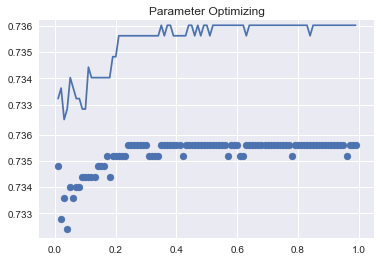

In [36]:
numb = np.arange(0.01, 1, 0.01)
yl = []
cl = []
for g in numb:
    lr = LogisticRegression(C=g, penalty='l1')
    lr.fit(X1, y)
    yl.append(lr.score(X1, y))
    cl.append(np.mean(cross_val_score(lr, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yl)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cl)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

In [37]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l1')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.735623003195

R-squared for the test set with PCA:
0.732576985413

Cross Validation Score with 5 folds with PCA:
[ 0.74900398  0.76494024  0.698       0.736       0.73      ]

R-squared for the training set with RFECV generated features:
0.785942492013

R-squared for the test set with RFECV generated features:
0.76904376013

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.78685259  0.80079681  0.748       0.762       0.812     ]

R-squared for the training set with Random Forest generated features:
0.784744408946

R-squared for the test set with Random Forest generated features:
0.763371150729

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.7749004   0.79880478  0.746       0.768       0.81      ]
It took the following time to complete this task: 0:00:01.317897


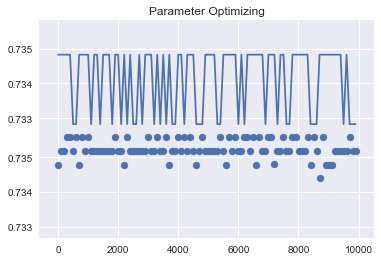

In [38]:
numb = np.arange(1, 10000, 100)

yr = []
cr = []
for g in numb:
    lr = LogisticRegression(C=g, penalty='l2')
    lr.fit(X1, y)
    yr.append(lr.score(X1, y))
    cr.append(np.mean(cross_val_score(lr, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yr)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cr)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

In [39]:
start = datetime.now()
#Let's compare our features in various models starting with Logistic Regression
lr = LogisticRegression(C=1, penalty='l2')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.73482428115

R-squared for the test set with PCA:
0.732576985413

Cross Validation Score with 5 folds with PCA:
[ 0.74701195  0.76294821  0.7         0.736       0.728     ]

R-squared for the training set with RFECV generated features:
0.786341853035

R-squared for the test set with RFECV generated features:
0.768233387358

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.78884462  0.80079681  0.748       0.766       0.81      ]

R-squared for the training set with Random Forest generated features:
0.787539936102

R-squared for the test set with Random Forest generated features:
0.766612641815

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.78286853  0.80677291  0.742       0.764       0.806     ]
It took the following time to complete this task: 0:00:00.465427


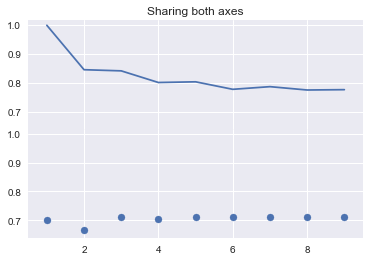

It took the following time to complete this task: 0:00:01.490801


In [40]:
numb = np.arange(1, 10, 1)
start = datetime.now()
yn = []
cv = []
for g in numb:
    neighbors = KNeighborsClassifier(n_neighbors=g)
    neighbors.fit(X1, y)
    yn.append(neighbors.score(X1, y))
    cv.append(np.mean(cross_val_score(neighbors, X1, y, cv=5)))
    
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yn)
ax1.set_title('Sharing both axes')
ax2.scatter(numb, cv)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

print('It took the following time to complete this task:', datetime.now() - start)

In [41]:
start = datetime.now()
neighbors = KNeighborsClassifier(n_neighbors=3)
testing_func(neighbors)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.841054313099

R-squared for the test set with PCA:
0.810372771475

Cross Validation Score with 5 folds with PCA:
[ 0.72709163  0.73505976  0.688       0.704       0.706     ]

R-squared for the training set with RFECV generated features:
0.856629392971

R-squared for the test set with RFECV generated features:
0.841977309562

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.75298805  0.74701195  0.722       0.744       0.754     ]

R-squared for the training set with Random Forest generated features:
0.840654952077

R-squared for the test set with Random Forest generated features:
0.809562398703

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.71912351  0.73505976  0.682       0.698       0.7       ]
It took the following time to complete this task: 0:00:00.788759


In [42]:
svc = SVC()
parameters = {'C':[1,2,3,4,5], 'gamma': 
              [0.01,0.02,0.03,0.04,0.05,0.10]}
grid = GridSearchCV(svc, parameters)
grid.fit(X1, y)
predicted = grid.predict(X1_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_

The best parameters are {'C': 1, 'gamma': 0.01} with a score of %0.7140575079872205


In [43]:
start = datetime.now()
#Now let's model with SVM
svc = SVC(C=parameters['C'], gamma=parameters['gamma'])
testing_func(svc)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.913338658147

R-squared for the test set with PCA:
0.927876823339

Cross Validation Score with 5 folds with PCA:
[ 0.7310757   0.74501992  0.708       0.69        0.712     ]

R-squared for the training set with RFECV generated features:
0.78714057508

R-squared for the test set with RFECV generated features:
0.763371150729

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.78884462  0.79880478  0.762       0.758       0.808     ]

R-squared for the training set with Random Forest generated features:
0.917332268371

R-squared for the test set with Random Forest generated features:
0.931928687196

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.72310757  0.74900398  0.706       0.692       0.714     ]
It took the following time to complete this task: 0:00:08.640492


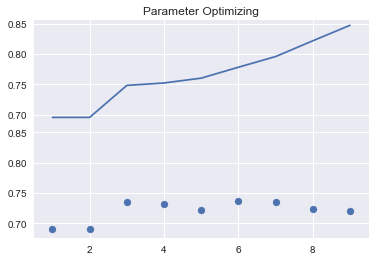

It took the following time to complete this task: 0:00:01.404321


In [44]:
numb = np.arange(1, 10, 1)
start = datetime.now()
yd = []
cd = []
for g in numb:
    clf = DecisionTreeClassifier(max_depth=g)
    clf.fit(X1, y)
    yd.append(clf.score(X1, y))
    cd.append(np.mean(cross_val_score(clf, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yd)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cd)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()
print('It took the following time to complete this task:', datetime.now() - start)

In [45]:
start = datetime.now()
clf = DecisionTreeClassifier(max_depth=6, random_state=42)
testing_func(clf)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.777955271565

R-squared for the test set with PCA:
0.815235008104

Cross Validation Score with 5 folds with PCA:
[ 0.76095618  0.74501992  0.726       0.724       0.736     ]

R-squared for the training set with RFECV generated features:
0.807108626198

R-squared for the test set with RFECV generated features:
0.808752025932

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.76095618  0.78286853  0.732       0.774       0.794     ]

R-squared for the training set with Random Forest generated features:
0.810702875399

R-squared for the test set with Random Forest generated features:
0.819286871961

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.7689243   0.74900398  0.734       0.744       0.762     ]
It took the following time to complete this task: 0:00:00.607685


In [46]:
start = datetime.now()
#Now let's model with Random Forest
rfc = RandomForestClassifier(n_estimators=10000, criterion='gini', max_depth=None, min_samples_split=2, 
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                      max_leaf_nodes=2, min_impurity_decrease=0.0, min_impurity_split=None, 
                                      bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                                      warm_start=False, class_weight=None)

testing_func(rfc)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.737619808307

R-squared for the test set with PCA:
0.698541329011

Cross Validation Score with 5 folds with PCA:
[ 0.75896414  0.72709163  0.7         0.708       0.744     ]

R-squared for the training set with RFECV generated features:
0.762779552716

R-squared for the test set with RFECV generated features:
0.751215559157

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.76693227  0.78286853  0.734       0.75        0.774     ]

R-squared for the training set with Random Forest generated features:
0.767172523962

R-squared for the test set with Random Forest generated features:
0.739870340357

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.77888446  0.7689243   0.742       0.76        0.768     ]
It took the following time to complete this task: 0:11:09.110625


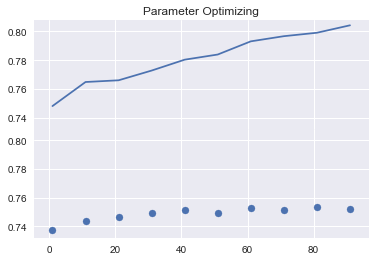

In [47]:
numb = np.arange(1, 100, 10)
start = datetime.now()
yg1 = []
cg1 = []
for g in numb:
    clf = GradientBoostingClassifier(loss='exponential', n_estimators=g)
    clf.fit(X1, y)
    yg1.append(clf.score(X1, y))
    cg1.append(np.mean(cross_val_score(clf, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yg1)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cg1)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

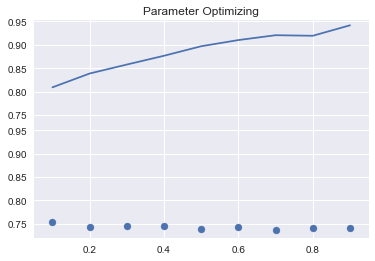

In [48]:
numb = np.arange(0.1, 1, 0.1)
start = datetime.now()
yg2 = []
cg2 = []
for g in numb:
    clf = GradientBoostingClassifier(loss='exponential', learning_rate=g)
    clf.fit(X1, y)
    yg2.append(clf.score(X1, y))
    cg2.append(np.mean(cross_val_score(clf, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yg2)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cg2)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

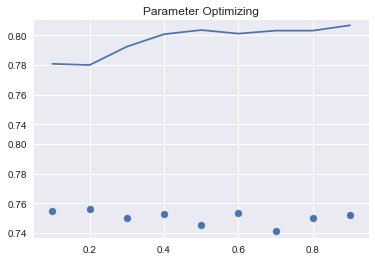

In [49]:
numb = np.arange(0.1, 1, 0.1)
start = datetime.now()
yg3 = []
cg3 = []
for g in numb:
    clf = GradientBoostingClassifier(loss='exponential', subsample=g)
    clf.fit(X1, y)
    yg3.append(clf.score(X1, y))
    cg3.append(np.mean(cross_val_score(clf, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yg3)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cg3)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

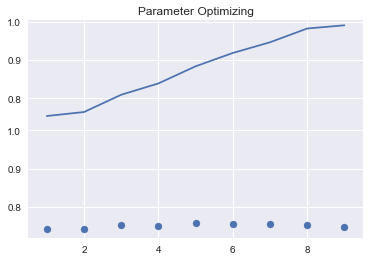

In [50]:
numb = np.arange(1, 10, 1)
start = datetime.now()
yg4 = []
cg4 = []
for g in numb:
    clf = GradientBoostingClassifier(loss='exponential', max_depth=g)
    clf.fit(X1, y)
    yg4.append(clf.score(X1, y))
    cg4.append(np.mean(cross_val_score(clf, X1, y, cv=5)))

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(numb, yg4)
ax1.set_title('Parameter Optimizing')
ax2.scatter(numb, cg4)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

In [51]:
start = datetime.now()
#Now let's model with Gradient Boosting
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.5, n_estimators=100, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=2, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

testing_func(clf)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the training set with PCA:
0.818690095847

R-squared for the test set with PCA:
0.862236628849

Cross Validation Score with 5 folds with PCA:
[ 0.76294821  0.76693227  0.71        0.734       0.736     ]

R-squared for the training set with RFECV generated features:
0.798322683706

R-squared for the test set with RFECV generated features:
0.803079416532

Cross Validation Score with 5 folds with RFECV generated features:
[ 0.78486056  0.77888446  0.742       0.762       0.808     ]

R-squared for the training set with Random Forest generated features:
0.831469648562

R-squared for the test set with Random Forest generated features:
0.846839546191

Cross Validation Score with 5 folds with Random Forest generated features:
[ 0.78884462  0.79083665  0.76        0.752       0.784     ]
It took the following time to complete this task: 0:00:05.329368


In [52]:

results2 = pd.DataFrame({'Train Score': Train_Score, 'Test Score': Test_Score, 'CV Fold 1': fold1,
                            'CV Fold 2': fold2, 'CV Fold 3': fold3, 'CV Fold 4': fold4, 'CV Fold 5': fold5})
results2['CV Mean'] = (results2['CV Fold 1'] + results2['CV Fold 2'] + results2['CV Fold 3'] + results2['CV Fold 4'] +
                       results2['CV Fold 5']) / 5
results = pd.concat([results, results2], axis=1)

results.head(24)

,Model,Feature Selection,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5,Test Score,Train Score,CV Mean
0,Logistic Regression,PCA,0.747012,0.762948,0.700,0.736,0.730,0.732577,0.734824,0.735192
1,Logistic Regression,RFECV,0.790837,0.800797,0.748,0.764,0.812,0.770665,0.786741,0.783127
2,Logistic Regression,Random Forest,0.782869,0.804781,0.744,0.764,0.806,0.762561,0.786342,0.780330
3,Lasso Regression,PCA,0.749004,0.764940,0.698,0.736,0.730,0.732577,0.735623,0.735589
4,Lasso Regression,RFECV,0.786853,0.800797,0.748,0.762,0.812,0.769044,0.785942,0.781930
5,Lasso Regression,Random Forest,0.774900,0.798805,0.746,0.768,0.810,0.763371,0.784744,0.779541
6,Ridge Regression,PCA,0.747012,0.762948,0.700,0.736,0.728,0.732577,0.734824,0.734792
7,Ridge Regression,RFECV,0.788845,0.800797,0.748,0.766,0.810,0.768233,0.786342,0.782728
8,Ridge Regression,Random Forest,0.782869,0.806773,0.742,0.764,0.806,0.766613,0.787540,0.780328
9,KNN,PCA,0.727092,0.735060,0.688,0.704,0.706,0.810373,0.841054,0.712030


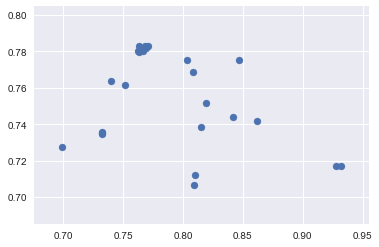

In [53]:
x = results['Test Score']
y = results['CV Mean']
plt.scatter(x, y)
plt.show()

In [54]:
results.describe()

,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5,Test Score,Train Score,CV Mean
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.763529,0.771082,0.725917,0.741250,0.764333,0.792848,0.799621,0.753222
std,0.022564,0.025503,0.023543,0.025962,0.039561,0.058682,0.049097,0.026010
min,0.719124,0.727092,0.682000,0.690000,0.700000,0.698541,0.734824,0.706837
25%,0.748506,0.748506,0.704500,0.731500,0.730000,0.759724,0.775260,0.735092
50%,0.764940,0.767928,0.733000,0.747000,0.765000,0.769854,0.786941,0.756573
75%,0.783367,0.798805,0.744500,0.762500,0.806500,0.816248,0.821885,0.779738
max,0.790837,0.806773,0.762000,0.774000,0.812000,0.931929,0.917332,0.783130
